# **Proyecto final (código)**

## Descripción

Al operador de telecomunicaciones Interconnect le gustaría poder pronosticar su tasa de cancelación de clientes. Si se descubre que un usuario o usuaria planea irse, se le ofrecerán códigos promocionales y opciones de planes especiales. El equipo de marketing de Interconnect ha recopilado algunos de los datos personales de sus clientes, incluyendo información sobre sus planes y contratos.

### Servicios de Interconnect

Interconnect proporciona principalmente dos tipos de servicios:

1. Comunicación por teléfono fijo. El teléfono se puede conectar a varias líneas de manera simultánea.
2. Internet. La red se puede configurar a través de una línea telefónica (DSL, *línea de abonado digital*) o a través de un cable de fibra óptica.

Algunos otros servicios que ofrece la empresa incluyen:

- Seguridad en Internet: software antivirus (*ProtecciónDeDispositivo*) y un bloqueador de sitios web maliciosos (*SeguridadEnLínea*).
- Una línea de soporte técnico (*SoporteTécnico*).
- Almacenamiento de archivos en la nube y backup de datos (*BackupOnline*).
- Streaming de TV (*StreamingTV*) y directorio de películas (*StreamingPelículas*)

La clientela puede elegir entre un pago mensual o firmar un contrato de 1 o 2 años. Puede utilizar varios métodos de pago y recibir una factura electrónica después de una transacción.

### Descripción de los datos

Los datos consisten en archivos obtenidos de diferentes fuentes:

- `contract.csv` — información del contrato;
- `personal.csv` — datos personales del cliente;
- `internet.csv` — información sobre los servicios de Internet;
- `phone.csv` — información sobre los servicios telefónicos.

En cada archivo, la columna `customerID` (ID de cliente) contiene un código único asignado a cada cliente. La información del contrato es válida a partir del 1 de febrero de 2020.

Característica objetivo: la columna `'EndDate'` es igual a `'No'`.

Métrica principal: AUC-ROC.

Métrica adicional: exactitud.

Criterios de evaluación:

- AUC-ROC < 0.75 — 0 SP
- 0.75 ≤ AUC-ROC < 0.81 — 4 SP
- 0.81 ≤ AUC-ROC < 0.85 — 4.5 SP
- 0.85 ≤ AUC-ROC < 0.87 — 5 SP
- 0.87 ≤ AUC-ROC < 0.88 — 5.5 SP
- AUC-ROC ≥ 0.88 — 6 SP

## Objetivo

- Crear un modelo que prediga la tasa de cancelación de los clientes de Interconnect.
- Obtener un valor de AUC-ROC en el modelo elegido mayor a 0.88

## Primera parte

### Importación de librerías

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import lightgbm as lgb
import xgboost as xgb

from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score, roc_auc_score

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from imblearn.combine import SMOTETomek
from collections import Counter

### Análisis exploratorio inicial

In [2]:
# Carga de datasets
contratos = pd.read_csv('contract.csv')
internet = pd.read_csv('internet.csv')
personal_data = pd.read_csv('personal.csv')
telefono = pd.read_csv('phone.csv')

In [3]:
# Exploración de datasets
def exploracion(data):
    '''
    Función para exploración inicial de datasets'
    '''
    display(data.info())
    display(data.sample(5))
    display(data.describe(include='all'))
    print('Valores ausentes:')
    display(data.isna().sum())
    print('Duplicados totales:', data.duplicated().sum())

    return

In [4]:
exploracion(contratos)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


None

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
5312,9564-KCLHR,2019-11-01,2019-12-01 00:00:00,Month-to-month,No,Mailed check,51.25,51.25
3960,7404-JLKQG,2019-11-01,No,Month-to-month,No,Electronic check,57.55,161.45
4184,0495-ZBNGW,2019-05-01,2019-10-01 00:00:00,Month-to-month,Yes,Bank transfer (automatic),79.90,343.95
471,3583-EKAPL,2019-11-01,2019-12-01 00:00:00,Month-to-month,Yes,Electronic check,55.00,55
1552,2245-ADZFJ,2017-07-01,No,Two year,No,Bank transfer (automatic),80.55,2471.6


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
count,7043,7043,7043,7043,7043,7043,7043.000000,7043
unique,7043,77,5,3,2,4,NaN,6531
top,7590-VHVEG,2014-02-01,No,Month-to-month,Yes,Electronic check,NaN,
freq,1,366,5174,3875,4171,2365,NaN,11
mean,NaN,NaN,NaN,NaN,NaN,NaN,64.761692,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,30.090047,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,18.250000,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,35.500000,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,70.350000,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,89.850000,NaN


Valores ausentes:


customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64

Duplicados totales: 0


Text(0.5, 1.0, 'Distribución de cargos mensuales')

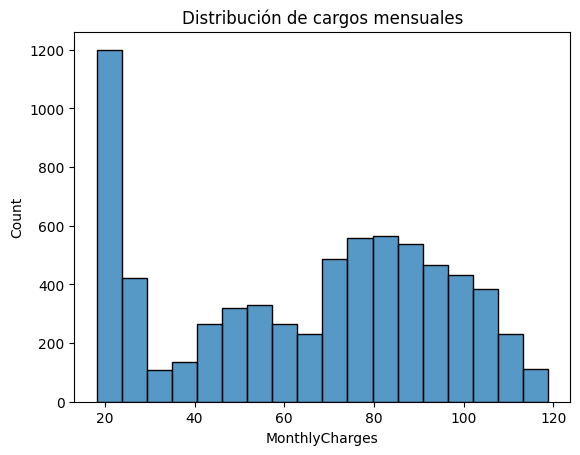

In [5]:
sns.histplot(contratos['MonthlyCharges'])
plt.title('Distribución de cargos mensuales')

<span style=color:green> **Comentario:** </span>

- No hay datos ausentes ni duplicados en este dataset.
- La columna EndDate tendría más sentido con valores binarios como Yes / No, en lugar de fechas específicas.
- Hay 5174 contratos activos y 1869 contratos terminados.
- Se requiere convertir la columna BeginDate a fecha, para calcular los meses que los clientes estuvieron activos antes de irse.
- La columna TotalCharges debería ser numérica.
- El 75% de los clientes paga menos de $90 USD al mes y cerca de 1200 clientes (17% de los contratos) paga $20 USD 
- La columna PaperlessBilling no la considero relevante para la predicción.

In [6]:
exploracion(internet)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


None

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
3778,8993-IZEUX,Fiber optic,No,No,No,No,No,No
2432,5038-ETMLM,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes
4036,2480-SQIOB,DSL,No,No,No,No,No,No
4430,0875-CABNR,Fiber optic,No,No,Yes,No,No,Yes
1720,8879-XUAHX,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,7590-VHVEG,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


Valores ausentes:


customerID          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64

Duplicados totales: 0


<span style=color:green> **Comentario:** </span>

- No hay datos ausentes ni duplicados en este dataset.
- El tipo de datos en cada columna es adecuado.
- Hay más IDs en este dataset (5517) que los contratos activos del dataset de contratos (5174), pero menos que el total de los IDs de ese dataset (7043), ¿por qué?
- Los 5517 datos de este dataset corresponden al 78% de los contratos totales (5517/7043).
- Todas las columnas son útiles para manenter, aunque podrían unificarse en una sola categoría con valores del 0 al 6, según el número de servicios adicionales contratados.

In [7]:
exploracion(personal_data)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


None

,customerID,gender,SeniorCitizen,Partner,Dependents
2821,4102-OQUPX,Male,1,Yes,No
558,2501-XWWTZ,Male,0,No,No
6434,6608-QQLVK,Male,0,No,No
5820,1752-OZXFY,Male,0,Yes,No
1799,9172-ANCRX,Female,0,No,No


,customerID,gender,SeniorCitizen,Partner,Dependents
count,7043,7043,7043.000000,7043,7043
unique,7043,2,NaN,2,2
top,7590-VHVEG,Male,NaN,No,No
freq,1,3555,NaN,3641,4933
mean,NaN,NaN,0.162147,NaN,NaN
std,NaN,NaN,0.368612,NaN,NaN
min,NaN,NaN,0.000000,NaN,NaN
25%,NaN,NaN,0.000000,NaN,NaN
50%,NaN,NaN,0.000000,NaN,NaN
75%,NaN,NaN,0.000000,NaN,NaN


Valores ausentes:


customerID       0
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64

Duplicados totales: 0


<span style=color:green> **Comentario:** </span>

- No hay datos ausentes ni duplicados en este dataset.
- El título de la columna gender no coincide con el estilo de las demás columnas.
- El número de IDs (7043) coincide con el dataset de contratos (7043).
- El tipo de dato en la columna SeniorCitizen no es adecuado, debería ser categórico, no numérico. 
- ¿Qué significa 1 y 0 en la columna SeniorCitizen?
- Todas las columnas podrían ser útiles para la predicción.

In [8]:
exploracion(telefono)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


None

,customerID,MultipleLines
1772,3764-MNMOI,No
1522,5047-LHVLY,No
5322,9584-EXCDZ,No
5219,2398-YPMUR,No
257,3727-OWVYD,No


,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,5575-GNVDE,No
freq,1,3390


Valores ausentes:


customerID       0
MultipleLines    0
dtype: int64

Duplicados totales: 0


<span style=color:green> **Comentario:** </span>

- No hay datos ausentes ni duplicados en este dataset.
- El número de IDs (6361) no coincide con el dataset de contratos (7043), ¿por qué?
- El tipo de dato es adecuado en ambas columnas.
- La columna MultipleLines puede ser útil para la predicción.

### Plan de trabajo

1. Unificar todos los dataframes en un solo, uniendo por customerId.
2. Unificar el estilo en los nombres de las columnas a camel case.
2. Excluir de la unión las columnas BeginDate y PaperlessBilling del dataframe de contratos.
2. Crear una columna que muestre los meses que los clientes estuvieron o han estado activos.
3. Cambiar las fechas de la columna EndDate por Yes, para tener solo dos valores: Yes / No
3. Convertir la columna TotalCharges a numérica.
4. Convertir la columna SeniorCitizen a categórica.
5. Todas las columnas categóricas requerirán codificación One Hot.
6. Se requerirá de estandarizar los datos, evaluar la distribución del objetivo y si es necesario, redimensionar con PCA.
7. Se crearán sets de entrenamiento y prueba en proporción 80:20
7. Se probarán modelos de clasificación binaria: regresión logísitica, bosque aleatorio con optimización de hiperparámetros, LGBMClassifier y XGBoost.

### Resúmen:
Unificar dataframes con categórias seleccionadas, corregir estilo, tipo de datos, cambiar valores y crear columnas en donde sea necesario. Codificar columnas categóricas, estandarizar los datos y redimensionar si es necesario. Crear sets de entrenamiento y prueba y entrenar distintos modelos de clasificación binaria hasta lograr un AUC-ROC mayor a 0.88

### Preguntas iniciales
1. ¿Qué significa que la información del contrato es valida a partir del 1 de febrero de 2020. 
2. ¿Por qué no hay consistencia en la cantidad de datos de todos los dataframes?
2. En caso de mantener solo el 78% de los datos de los contratos totales (los 5517 datos del dataframe internet), ¿es suficiente para el entrenamiento de los modelos?
2. ¿Cómo se obtuvo y qué significa la columna TotalCharges del dataframe contratos?
3. ¿Qué significa 0 y 1 en la columna SeniorCitizen?

## Segunda parte

### Modificación y exploración de dataframes

#### Contratos

In [9]:
# Cambiar a tipo datetime columna BeginDate
contratos['BeginDate'] = pd.to_datetime(contratos['BeginDate'])

In [10]:
# Crear columna con fechas de término o vigencia del contrato (1/02/2020)
# Contratos vigentes
contratos.loc[contratos['EndDate'] == 'No',
              'Vigencia'] = pd.to_datetime('2020-02-01')

# Contratos cerrados
contratos.loc[contratos['EndDate'] != 'No',
              'Vigencia'] = contratos.loc[contratos['EndDate'] != 'No', 'EndDate']

In [11]:
# Crear columna con duración de contratos (en días)
contratos['ContractTime'] = contratos['Vigencia'] - contratos['BeginDate']
contratos['ContractDuration'] = contratos['ContractTime'].dt.days

In [12]:
# Mostrar resultado
contratos[['BeginDate', 'EndDate', 'Vigencia',
           'ContractTime', 'ContractDuration']]

,BeginDate,EndDate,Vigencia,ContractTime,ContractDuration
0,2020-01-01,No,2020-02-01,31 days,31
1,2017-04-01,No,2020-02-01,1036 days,1036
2,2019-10-01,2019-12-01 00:00:00,2019-12-01,61 days,61
3,2016-05-01,No,2020-02-01,1371 days,1371
4,2019-09-01,2019-11-01 00:00:00,2019-11-01,61 days,61
...,...,...,...,...,...
7038,2018-02-01,No,2020-02-01,730 days,730
7039,2014-02-01,No,2020-02-01,2191 days,2191
7040,2019-03-01,No,2020-02-01,337 days,337
7041,2019-07-01,2019-11-01 00:00:00,2019-11-01,123 days,123


In [13]:
# Cambiar columna EndDate a valores Yes / No
contratos.loc[contratos['EndDate'] != 'No', 'EndDate'] = 'Yes'

Text(0.5, 1.0, 'Duración de contratos cerrados (días)')

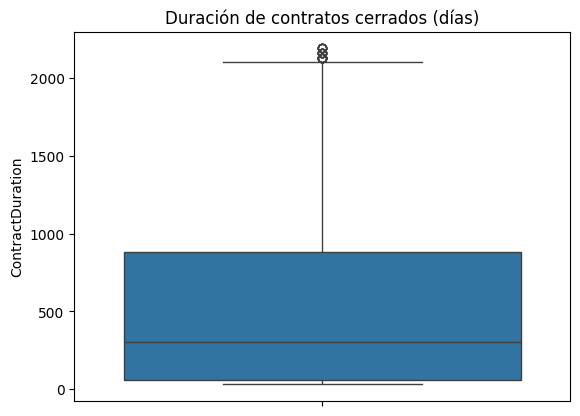

In [14]:
# Exploración de días de contratos cerrados
sns.boxplot(contratos.query('EndDate == "Yes"')['ContractDuration'])
plt.title('Duración de contratos cerrados (días)')

Text(0.5, 1.0, 'Duración de contratos vigentes (días)')

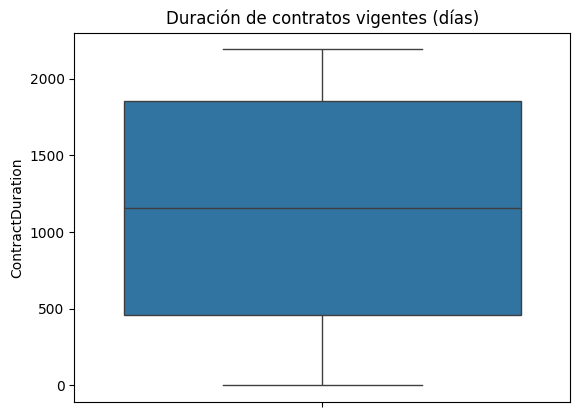

In [15]:
# Exploración de días de contratos vigentes
sns.boxplot(contratos.query('EndDate == "No"')['ContractDuration'])
plt.title('Duración de contratos vigentes (días)')

<span style=color:green> **Comentario:** </span>

- El 75% de los contratos cerrados duró menos de 900 días con una mediana cercana a los 300 días.
- El 25% de los clientes cerró su contrato a los 60 días.
- El 75% de los contratos vigentes llevan cerca de 1900 días con una media cercana a los 1200 días

In [16]:
# Cambiar valores Yes y No por 1 y 0, respectivamente
contratos['EndDate'] = contratos['EndDate'].map({'Yes': 1, 'No': 0})

In [17]:
contratos['EndDate'].value_counts()

EndDate
0    5174
1    1869
Name: count, dtype: int64

In [18]:
# Cambiar columna TotalCharges a numérica
contratos['TotalCharges'] = pd.to_numeric(
    contratos['TotalCharges'], errors='coerce')

In [19]:
contratos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype          
---  ------            --------------  -----          
 0   customerID        7043 non-null   object         
 1   BeginDate         7043 non-null   datetime64[ns] 
 2   EndDate           7043 non-null   int64          
 3   Type              7043 non-null   object         
 4   PaperlessBilling  7043 non-null   object         
 5   PaymentMethod     7043 non-null   object         
 6   MonthlyCharges    7043 non-null   float64        
 7   TotalCharges      7032 non-null   float64        
 8   Vigencia          7043 non-null   datetime64[ns] 
 9   ContractTime      7043 non-null   timedelta64[ns]
 10  ContractDuration  7043 non-null   int64          
dtypes: datetime64[ns](2), float64(2), int64(2), object(4), timedelta64[ns](1)
memory usage: 605.4+ KB


In [20]:
# Eliminación de valores ausentes
contratos.dropna(inplace=True)

In [21]:
# Tamaño final del dataframe
contratos.shape

(7032, 11)

In [22]:
# Exploración de contratos cerrados por pagos totales
closed_contracts = contratos.query('EndDate == 1')

In [23]:
# Pagos totales de clientes que cancelaron a los 60 días
closed_contracts.query('ContractDuration <= 61')['TotalCharges'].describe()

count    503.000000
mean      76.116103
std       44.137423
min       18.850000
25%       45.500000
50%       70.750000
75%       89.225000
max      242.800000
Name: TotalCharges, dtype: float64

In [24]:
# Pagos totales de clientes que cancelaron a los 300 días
closed_contracts.query('ContractDuration <= 300')['TotalCharges'].describe()

count    923.000000
mean     220.148104
std      212.430838
min       18.850000
25%       69.825000
50%      130.750000
75%      324.450000
max      923.500000
Name: TotalCharges, dtype: float64

In [25]:
# Pagos totales de clientes que cancelaron a los 900 días
closed_contracts.query('ContractDuration <= 900')['TotalCharges'].describe()

count    1409.000000
mean      628.388254
std       696.920057
min        18.850000
25%        80.300000
50%       324.250000
75%       973.450000
max      3152.500000
Name: TotalCharges, dtype: float64

<span style=color:green> **Comentario:** </span>

- El 75% de clientes que cerraron su contrato a los 60 días pagó en total $89 dólares y en promedio $76.
- El 75% de los clientes que cerraron su contrato a los 300 días pagó en total $324 dólares y en promedio $220.
- El 75% de los clientes que cerraron su contrato a los 900 días pagó en total $973 dólares y en promedio $628.


#### Internet

#### Personal_data

In [26]:
# Cambio a tipo object en columna SeniorCitizen
personal_data['SeniorCitizen'] = personal_data['SeniorCitizen'].astype(
    'object')

### Unión de dataframes

In [27]:

# Unión de contratos con internet por customerID
# Se excluyen las columnas BeginDate, PaperlessBilling y las creadas para la columna ContractDuration

no_columns = ['BeginDate', 'PaperlessBilling', 'Vigencia', 'ContractTime']
contratos_filered = contratos.drop(columns=no_columns)

merge_1 = pd.merge(contratos_filered, internet)

In [28]:
merge_1.shape

(5512, 14)

<span style=color:green> **Comentario:** </span>

- En esta unión se mantienen 5512 costumerID, que corresponden al 78% de los contratos existentes en el dataframe contratos.

In [29]:
# Union de merge_1 con personal_data por costumerID
# Se mantienen todas las columnas de ambos dataframes

merge_2 = pd.merge(merge_1, personal_data, on='customerID')

In [30]:
merge_2.shape

(5512, 18)

In [31]:
# Unión con dataframe telefono
merge_3 = pd.merge(merge_2, telefono, on='customerID')

In [32]:
merge_3.shape

(4832, 19)

In [33]:
merge_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4832 entries, 0 to 4831
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        4832 non-null   object 
 1   EndDate           4832 non-null   int64  
 2   Type              4832 non-null   object 
 3   PaymentMethod     4832 non-null   object 
 4   MonthlyCharges    4832 non-null   float64
 5   TotalCharges      4832 non-null   float64
 6   ContractDuration  4832 non-null   int64  
 7   InternetService   4832 non-null   object 
 8   OnlineSecurity    4832 non-null   object 
 9   OnlineBackup      4832 non-null   object 
 10  DeviceProtection  4832 non-null   object 
 11  TechSupport       4832 non-null   object 
 12  StreamingTV       4832 non-null   object 
 13  StreamingMovies   4832 non-null   object 
 14  gender            4832 non-null   object 
 15  SeniorCitizen     4832 non-null   object 
 16  Partner           4832 non-null   object 


In [34]:
# Eliminación de customerID por ser irrelevante para la predicción
merge_3.drop('customerID', axis=1, inplace=True)

In [35]:
merge_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4832 entries, 0 to 4831
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   EndDate           4832 non-null   int64  
 1   Type              4832 non-null   object 
 2   PaymentMethod     4832 non-null   object 
 3   MonthlyCharges    4832 non-null   float64
 4   TotalCharges      4832 non-null   float64
 5   ContractDuration  4832 non-null   int64  
 6   InternetService   4832 non-null   object 
 7   OnlineSecurity    4832 non-null   object 
 8   OnlineBackup      4832 non-null   object 
 9   DeviceProtection  4832 non-null   object 
 10  TechSupport       4832 non-null   object 
 11  StreamingTV       4832 non-null   object 
 12  StreamingMovies   4832 non-null   object 
 13  gender            4832 non-null   object 
 14  SeniorCitizen     4832 non-null   object 
 15  Partner           4832 non-null   object 
 16  Dependents        4832 non-null   object 


In [36]:
# Renombrar columna gender para unificar el estilo
merge_3.rename(columns={'gender': 'Gender'}, inplace=True)

In [37]:
merge_3.columns

Index(['EndDate', 'Type', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges',
       'ContractDuration', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'Gender', 'SeniorCitizen', 'Partner', 'Dependents', 'MultipleLines'],
      dtype='object')

<span style=color:green> **Comentarios:** </span>

- Cambio de datos y tipo de datos en dataframe contratos y personal data.
- Eliminación de valores ausentes.
- Eliminación de columnas no potenciales para la predicción.
- Creación de columna ContractDuration que muestra los días que ha durado activo un contrato.
- Unión de todos los dataframes originales en uno solo, conservando 18 columnas totales (**17 características y 1 objetivo**).
- Unificación de estilo en el nombre de las columnas.
- El dataframe unificado contiene data de 4832 clientes.

### Separación de características y objetivo

In [38]:
# Separación de características y objetivo
features = merge_3.drop('EndDate', axis=1)
target = merge_3['EndDate']

In [39]:
# Tamaño conjunto de entranamiento
features.shape

(4832, 17)

In [40]:
# Tamaño objetivo
target.shape

(4832,)

<span style=color:green> **Comentarios:** </span>

- Separación efectiva de características (17) y objetivo.
- 4832 observaciones conservadas.

### Distribucion de características numéricas

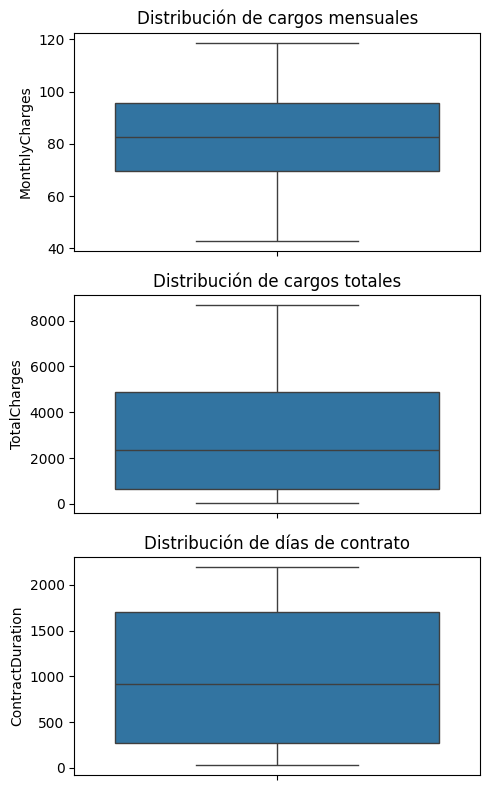

In [41]:
# Distribución de características numéricas
# Cuadrícula 3 x 1
fig, axs = plt.subplots(3, 1, figsize=(5, 8))

# Distribución columna MonthlyCharges
sns.boxplot(features['MonthlyCharges'], ax=axs[0])
# Distribución columna TotalCharges
sns.boxplot(features['TotalCharges'], ax=axs[1])
# Distribución columna ContractDuration
sns.boxplot(features['ContractDuration'], ax=axs[2])


# Títulos
axs[0].set_title('Distribución de cargos mensuales')
axs[1].set_title('Distribución de cargos totales')
axs[2].set_title('Distribución de días de contrato')

# Ajustar el diseño
plt.tight_layout()

# Mostrar la figura
plt.show()

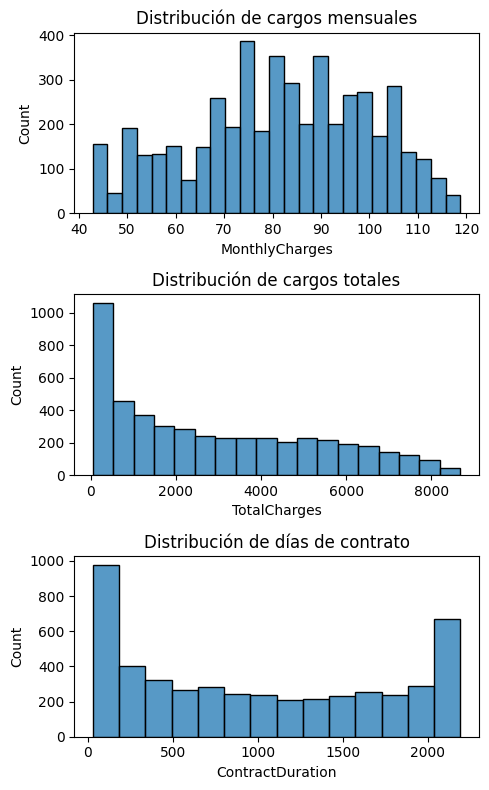

In [63]:
# Distribución de características numéricas
# Cuadrícula 3 x 1
fig, axs = plt.subplots(3, 1, figsize=(5, 8))

# Distribución columna MonthlyCharges
sns.histplot(features['MonthlyCharges'], ax=axs[0])
# Distribución columna TotalCharges
sns.histplot(features['TotalCharges'], ax=axs[1])
# Distribución columna ContractDuration
sns.histplot(features['ContractDuration'], ax=axs[2])


# Títulos
axs[0].set_title('Distribución de cargos mensuales')
axs[1].set_title('Distribución de cargos totales')
axs[2].set_title('Distribución de días de contrato')

# Ajustar el diseño
plt.tight_layout()

# Mostrar la figura
plt.show()

<span style=color:green> **Comentario:** </span>

- Los cargos mensuales tienen una media cercana a $85 dólares, sin valores atípicos.
- Los cargos totales tienen una mediana cercana a $2500 dólares, sin valores atípicos.
- Los días de contrato tienen una media cercana a 975 días, sin valores atípicos.
- No se necesitan ajustes previos al escalamiento de los datos por valores atípicos.

### Creación de sets de entrenamiento y prueba

In [42]:
# División en entrenamiento y prueba
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.2, random_state=325)

### Balance de clases

Text(0.5, 1.0, 'Balance de clases del objetivo')

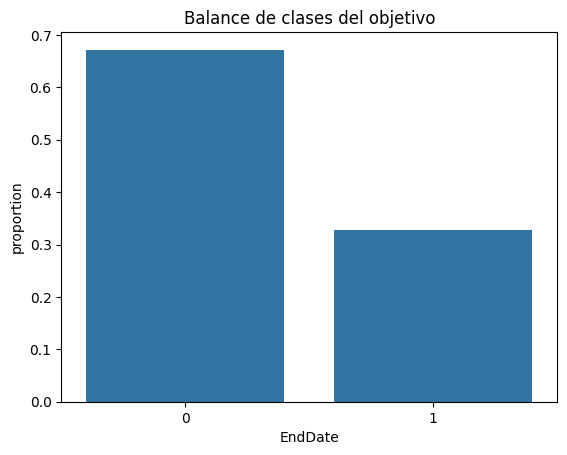

In [43]:
sns.barplot(target.value_counts(normalize=True))
plt.title('Balance de clases del objetivo')

<span style=color:green> **Comentario:** </span>

- El objetivo está desbalanceado, hay cerca del doble de valores 0 que 1.
- Se requiere de una técnica para rebalancear.

### Preparación de características

#### Codificación OHE de caraterísticas categóricas

In [44]:
# Selección de columnas categoricas
categorical_cols = features_train.select_dtypes(include=['object']).columns

In [45]:
# Creacion del codificador OneHotEncoder
encoder = OneHotEncoder(drop='if_binary', sparse_output=False)

# Ajuste del codificador solo al conjunto de entrenamiento
encoder.fit(features_train[categorical_cols])

OneHotEncoder(drop='if_binary', sparse_output=False)

In [46]:
# Transformación de ambos conjuntos
X_train_encoded = encoder.transform(features_train[categorical_cols])
X_test_encoded = encoder.transform(features_test[categorical_cols])

In [47]:
# Obtener nombres de características codificadas
encoded_feature_names = encoder.get_feature_names_out(
    input_features=categorical_cols)

In [48]:
# Creación de dataframe con los nuevos nombres de columnas codificadas y restauración de índices
X_train_encoded = pd.DataFrame(np.array(
    X_train_encoded), columns=encoded_feature_names, index=features_train.index)
X_test_encoded = pd.DataFrame(np.array(
    X_test_encoded), columns=encoded_feature_names, index=features_test.index)

In [49]:
# Eliminación de las columnas categoricas originales de los dataframes.
X_train_numerical = features_train.drop(categorical_cols, axis=1)
X_test_numerical = features_test.drop(categorical_cols, axis=1)

# Concatenar los dataframes codificados con los dataframes numericos.
X_train = pd.concat([X_train_numerical, X_train_encoded], axis=1)
X_test = pd.concat([X_test_numerical, X_test_encoded], axis=1)

In [50]:
print(X_train.shape)
print(X_test.shape)

(3865, 22)
(967, 22)


In [51]:
X_train.sample()

,MonthlyCharges,TotalCharges,ContractDuration,Type_Month-to-month,Type_One year,Type_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,...,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,Gender_Male,SeniorCitizen_1,Partner_Yes,Dependents_Yes,MultipleLines_Yes
991,101.45,2948.6,883,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0


<span style=color:green> **Comentario:** </span>

- Después de la codifición One Hot, las características pasaron de 17 a 22.
- Se tiene un conjunto de entrenamiento con 3865 filas, 22 características y uno de prueba con 967 filas y 22 características
- Las características numéricas requieren escalamiento. No se van a incluir las características binarias del OHE, ya que se encuentran en el rango adecuado.

#### Remuestreo en conjunto de entrenamiento

In [52]:
# Aplicar SMOTE-Tomek al conjunto de entrenamiento
smote_tomek = SMOTETomek(random_state=42)
X_resampled, y_resampled = smote_tomek.fit_resample(X_train, target_train)

In [53]:
# Mostrar el conteo de clases antes y después de SMOTE-Tomek
print("Conteo de clases antes de SMOTE-Tomek:", Counter(target_train))
print("Conteo de clases después de SMOTE-Tomek:", Counter(y_resampled))

Conteo de clases antes de SMOTE-Tomek: Counter({0: 2587, 1: 1278})
Conteo de clases después de SMOTE-Tomek: Counter({1: 2277, 0: 2277})


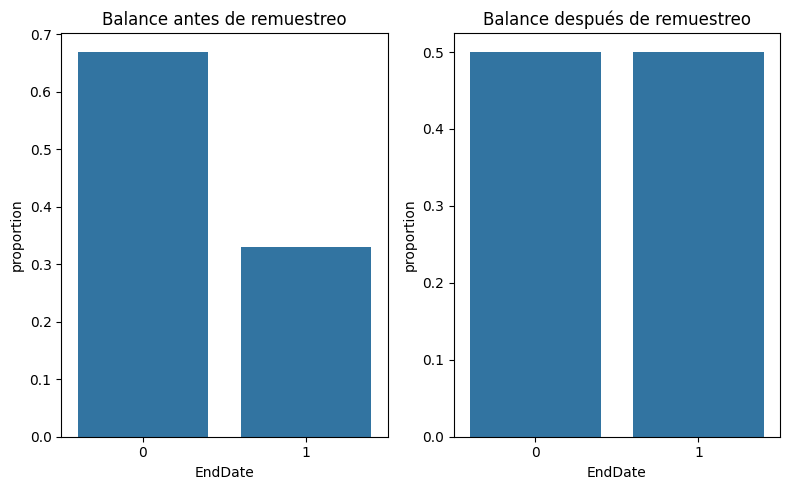

In [54]:
# Gráfico comparativo antes y después del balance de clases
# Cuadrícula de 1 x 2
fig, axs = plt.subplots(1, 2, figsize=(8, 5))

# Gráfico antes de remuestreo
sns.barplot(target_train.value_counts(normalize=True), ax=axs[0])

# Gráfico después de remuestreo
sns.barplot(y_resampled.value_counts(normalize=True), ax=axs[1])

# Títulos
axs[0].set_title('Balance antes de remuestreo')
axs[1].set_title('Balance después de remuestreo')

# Ajustar el diseño
plt.tight_layout()

# Mostrar la figura
plt.show()

<span style=color:green> **Comentario:** </span>

- Previo al remuestreo, el 65% de los datos eran 0 (No) y el 35% eran 1 (Yes).
- Después del remuestreo, ambas clases están al 50%

#### Estandarización de características numéricas

In [55]:
# Creacion de escalador
scaler = StandardScaler()

In [56]:
# Columnas a escalar
cols_scaled = X_train_numerical.columns

# Ajuste de escalador con datos numericos de entrenamiento
scaler.fit(X_resampled[cols_scaled])

StandardScaler()

In [57]:
# Transformación de ambos conjuntos
X_train_scaled = pd.DataFrame(scaler.transform(
    X_resampled[cols_scaled]), columns=cols_scaled)
X_test_scaled = pd.DataFrame(scaler.transform(
    X_test[cols_scaled]), columns=cols_scaled)

# Restauración de los indices originales
X_train_scaled.index = X_resampled.index
X_test_scaled.index = X_test.index

# Eliminación de las columnas numéricas originales de los dataframes.
X_resampled_binary = X_resampled.drop(cols_scaled, axis=1)
X_test_binary = X_test.drop(cols_scaled, axis=1)

# Concatenar los dataframes escalados con los dataframes binarios.
X_train = pd.concat([X_train_scaled, X_resampled_binary], axis=1)
X_test = pd.concat([X_test_scaled, X_test_binary], axis=1)

In [58]:
# Mostrar conjuntos
display(X_train.head())
X_test.head()

,MonthlyCharges,TotalCharges,ContractDuration,Type_Month-to-month,Type_One year,Type_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,...,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,Gender_Male,SeniorCitizen_1,Partner_Yes,Dependents_Yes,MultipleLines_Yes
0,0.191051,0.599622,0.693742,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0
1,1.681193,1.910780,1.423456,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,-0.618443,0.369658,0.774821,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0
3,-0.369153,-0.318264,-0.234018,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.157439,-0.830288,-0.923857,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0


,MonthlyCharges,TotalCharges,ContractDuration,Type_Month-to-month,Type_One year,Type_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,...,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,Gender_Male,SeniorCitizen_1,Partner_Yes,Dependents_Yes,MultipleLines_Yes
1728,-0.624045,-1.033858,-1.125891,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
3898,1.331066,2.083766,1.666694,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0
3981,-0.668861,-1.034193,-1.127220,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3417,0.720444,-0.752111,-0.841448,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
712,-1.797672,-1.042635,-1.125891,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [59]:
# Prueba de efectividad en el escalamiento de set de entrenamiento
# Verificacion de medias y desviación estándar
X_train_scaled.describe()

,MonthlyCharges,TotalCharges,ContractDuration
count,4.554000e+03,4.554000e+03,4.554000e+03
mean,-4.711987e-16,-1.622671e-16,8.737460e-17
std,1.000110e+00,1.000110e+00,1.000110e+00
min,-2.167406e+00,-1.045400e+00,-1.127220e+00
25%,-6.380502e-01,-8.909159e-01,-9.637320e-01
50%,3.284823e-02,-3.332937e-01,-2.752224e-01
75%,7.620830e-01,7.584642e-01,9.383091e-01
max,2.081738e+00,2.575157e+00,1.745115e+00


In [60]:
# Prueba de efectividad en el escalamiento de set de entrenamiento
# Verificacion de medias y desviación estándar
X_test_scaled.describe()

,MonthlyCharges,TotalCharges,ContractDuration
count,967.000000,967.000000,967.000000
mean,0.012064,0.173847,0.196884
std,1.028113,1.004300,0.984326
min,-2.136595,-1.044939,-1.127220
25%,-0.668861,-0.763852,-0.763692
50%,0.093015,-0.045692,0.128845
75%,0.800273,0.985730,1.100468
max,2.073335,2.537283,1.745115


<span style=color:green> **Comentario:** </span>

- La estandarización fue efectiva, los valores de media y desviación estándar de las columnas numericas no binarias, están cercanos a 0 y 1, respectivamente, en ambos conjuntos (prueba y entrenamiento).
- La preparación de los datos está completa, se realizaron:
    - Codificación OHE de características categóricas
    - Remuestreo, alcanzando un balance 50:50 en las clases 0 y 1 del objetivo
    - Estandarización de características numéricas

In [62]:
print(X_train.shape, X_test.shape)

(4554, 22) (967, 22)


## Tercera parte

### Creación de modelos predictivos

#### Dummy clasifier

In [59]:
# Crear modelo dummy con estrategia estratificada para respetar la distribución de clases
dummy_clf = DummyClassifier(strategy='stratified', random_state=42)

# Ajuste del modelo dummy
dummy_clf.fit(X_train, y_resampled)

DummyClassifier(random_state=42, strategy='stratified')

In [ ]:
# Probabilidades de predicción del modelo
y_pred_proba_dummy = dummy_clf.predict_proba(X_test)[:, 1]

# Predicciones del modelo
y_pred_dummy = dummy_clf.predict(X_test)

# Evaluar rendimiento del modelo dummy
accuracy_log = accuracy_score(target_test, y_pred_dummy)
roc_auc_log = roc_auc_score(target_test, y_pred_proba_dummy)

print(f'Accuracy modelo dummy: {accuracy_log:.2f}')
print(f'ROC_AUC modelo dummy: {roc_auc_log:.2f}')

Accuracy modelo dummy: 0.51
ROC_AUC modelo dummy: 0.51


<span style=color:green> **Comentario:** </span>

El modelo dummy obtuvo un rendimiento de 0.51 en ambas métricas (accuracy y ROC_AUC), en línea con la distribución balanceada de las clases.

#### Modelo 1: regresión logística

In [ ]:
# Configuración de la validación cruzada
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Creación de modelo de regresión logística
log_reg = LogisticRegression(solver='liblinear')

# Realizar la validación cruzada y obtener los scores
scores = cross_val_score(log_reg, X_train, y_resampled,
                         cv=cv, scoring='accuracy')

# Imprimir los scores de cada fold y el score promedio
print("Scores de validación cruzada:", scores)
print(f'Score promedio: {np.mean(scores):.2f}')

Scores de validación cruzada: [0.77058178 0.76948408 0.75521405 0.75521405 0.76923077]
Score promedio: 0.76


In [ ]:
# Entrenamiento completo
log_reg.fit(X_train, y_resampled)

# Probabilidades de predicción del modelo
y_pred_proba = log_reg.predict_proba(X_test)[:, 1]

# Predicciones del modelo
y_pred = log_reg.predict(X_test)

# Evaluar rendimiento del modelo dummy
accuracy_log = accuracy_score(target_test, y_pred)
roc_auc_log = roc_auc_score(target_test, y_pred_proba)

print(f'Accuracy modelo regresión: {accuracy_log:.2f}')
print(f'ROC_AUC modelo regresión: {roc_auc_log:.2f}')

Accuracy modelo regresión: 0.75
ROC_AUC modelo regresión: 0.83


<span style=color:green> **Comentario:** </span>

El modelo de regresión logística sin ajuste de hiperparámetros, obtuvo un accuracy de 0.76 en el conjunto de entrenamiento y de 0.75 y un **roc_auc_score de 0.83** en el conjunto de prueba.

#### Modelo 2: bosque aleatorio

In [63]:
# Hiperparametros a probar
param_grid = {
    'n_estimators': [200, 500, 1000],
    'max_depth': [10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [ ]:
# Creación del modelo de bosque aleatorio
# Se usa gridsearch con validación cruzada para optimizar hiperparámetros
# Se usan las mismas variables de validación cruzada y scoring que en la regresión logística
rf_clf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(rf_clf, param_grid, cv=cv, scoring='accuracy')
grid_search.fit(X_train, y_resampled)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [10, 15], 'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [200, 500, 1000]},
             scoring='accuracy')

In [65]:
# Resultados
print("Mejores hiperparámetros:", grid_search.best_params_)
print(f"Mejor score accuracy: {grid_search.best_score_:.2f}")

Mejores hiperparámetros: {'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Mejor score accuracy: 0.86


In [ ]:
# Mejor modelo
best_rf_clf = grid_search.best_estimator_

# Realizar predicciones en el conjunto de prueba
# Probabilidades para la clase positiva
y_pred_proba = best_rf_clf.predict_proba(X_test)[:, 1]
y_pred = best_rf_clf.predict(X_test)  # Predicciones de clase

# Calcular roc_auc_score en el conjunto de prueba
roc_auc_test = roc_auc_score(target_test, y_pred_proba)

# Calcular accuracy en el conjunto de prueba
accuracy_test = accuracy_score(target_test, y_pred)

# Imprimir resultados en el conjunto de prueba
print(f"ROC AUC en el conjunto de prueba: {roc_auc_test:.2f}")
print(f"Accuracy en el conjunto de prueba: {accuracy_test:.2f}")

ROC AUC en el conjunto de prueba: 0.85
Accuracy en el conjunto de prueba: 0.80


<span style=color:green> **Comentario:** </span>

- El modelo de bosque aleatorio obtuvo un accuracy de 0.86 en el conjunto de entrenamiento, lo cual representa una mejoría de 15% sobre el desempeño del modelo de regresión logística.
- En el conjunto de prueba, obtuvo un accuracy de 0.80 y un **score roc_auc de 0.85**
- Los mejores hiperparametros fueron: {'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}

##### Calculo de importancia de las características

In [ ]:
# Importancia de la permutación
result = permutation_importance(
    best_rf_clf, X_test, target_test, n_repeats=10, random_state=42)

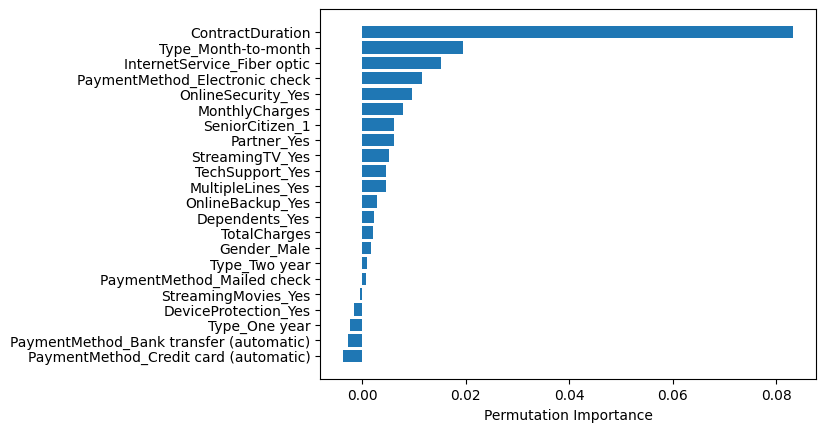

In [68]:
# Visualizar la importancia de las características
sorted_idx = result.importances_mean.argsort()
plt.barh(X_test.columns[sorted_idx], result.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")
plt.show()

<span style=color:green> **Comentario:** </span>

- En este modelo, las cinco características con mayor importancia para la cancelación de los clientes son:

    1. Duración del contrato
    2. Contrato de pagos mensuales
    3. Servicio de internet de fibra óptica
    4. Pagos con cheque electrónico
    5. Servicio de seguridad en línea 

- Las cinco características con menos importancia para la cancelación de los clientes son:

    1. Pago con tarjeta de crédito
    2. Pago por transferencia bancaria
    3. Contratos anuales
    4. Servicio de protección de dispositivos
    5. Servicio de streaming de películas 


#### Modelo 3: descenso de gradiente Light GBM

In [ ]:
# Definir la cuadrícula de parámetros
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [200, 400, 800],
    'max_depth': [6, 7],
    'reg_alpha': [0.3, 0.5, 0.7],
    'reg_lambda': [0.3, 0.5, 0.7]
}

In [ ]:
# Crear el modelo LightGBM
lgbm_model = lgb.LGBMClassifier(
    objective='binary', random_state=42, verbose=-1)

# Crear el objeto GridSearchCV
grid_search = GridSearchCV(lgbm_model, param_grid, cv=cv, scoring='accuracy')

# Realizar la búsqueda
grid_search.fit(X_train, y_resampled)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=LGBMClassifier(objective='binary', random_state=42,
                                      verbose=-1),
             param_grid={'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [6, 7], 'n_estimators': [200, 400, 800],
                         'reg_alpha': [0.3, 0.5, 0.7],
                         'reg_lambda': [0.3, 0.5, 0.7]},
             scoring='accuracy')

In [71]:
# Resultados
print("Mejores hiperparámetros:", grid_search.best_params_)
print(f"Mejor score accuracy: {grid_search.best_score_:.2f}")

Mejores hiperparámetros: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 400, 'reg_alpha': 0.3, 'reg_lambda': 0.5}
Mejor score accuracy: 0.89


In [ ]:
# Mejor modelo
best_lgbm = grid_search.best_estimator_

# Realizar predicciones en el conjunto de prueba
# Probabilidades para la clase positiva
y_pred_proba = best_lgbm.predict_proba(X_test)[:, 1]
y_pred = best_lgbm.predict(X_test)  # Predicciones de clase

# Calcular roc_auc_score en el conjunto de prueba
roc_auc_test = roc_auc_score(target_test, y_pred_proba)

# Calcular accuracy en el conjunto de prueba
accuracy_test = accuracy_score(target_test, y_pred)

# Imprimir resultados en el conjunto de prueba
print(f"ROC AUC en el conjunto de prueba: {roc_auc_test:.2f}")
print(f"Accuracy en el conjunto de prueba: {accuracy_test:.2f}")

ROC AUC en el conjunto de prueba: 0.89
Accuracy en el conjunto de prueba: 0.84


<span style=color:green> **Comentario:** </span>

- El modelo LGBM obtuvo un accuracy de 0.89 en el conjunto de entrenamiento, lo que representa una mejoría de 3% sobre el desempeño del modelo de bosque aleatorio. 
- En el conjunto de prueba, obtuvo un accuracy de 0.84 y un **score roc_auc de 0.89** 
- Los mejores hiperparametros fueron: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 400, 'reg_alpha': 0.3, 'reg_lambda': 0.5}

##### Calculo de importancia de las características

In [ ]:
# Importancia de la permutación
result = permutation_importance(
    best_lgbm, X_test, target_test, n_repeats=10, random_state=42)

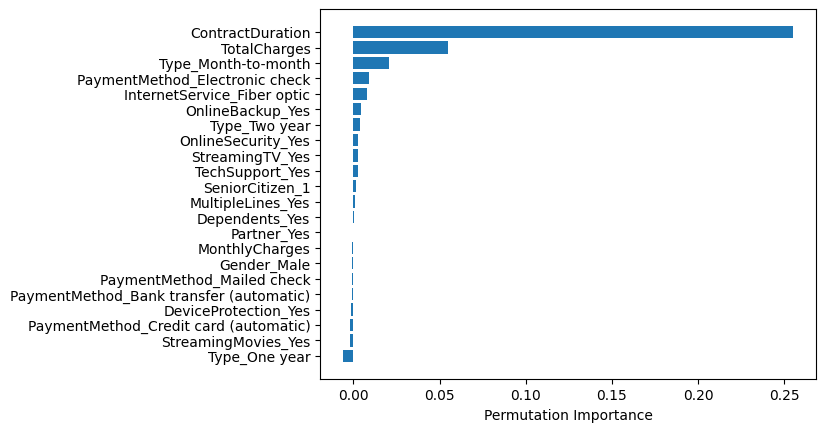

In [74]:
# Visualizar la importancia de las características
sorted_idx = result.importances_mean.argsort()
plt.barh(X_test.columns[sorted_idx], result.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")
plt.show()

<span style=color:green> **Comentario:** </span>

- En este modelo, las cinco características con mayor importancia para la cancelación de los clientes son:
    1. Duración del contrato
    2. Pagos totales realizados
    2. Contrato de pagos mensuales
    4. Pagos con cheque electrónico
    5. Servicio de internet de fibra óptica

- Las cinco características con menos importancia para la cancelación de los clientes son:

    1. Contratos anuales
    2. Servicio de streaming de películas 
    3. Pagos con tarjeta de crédito
    4. Servicio de protección de dispositivos
    5. Pagos por transferencia bancaria


#### Modelo 4: descenso de gradiente XGBoost

In [75]:
# Definir la cuadrícula de parámetros
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 6, 9],
    'subsample': [0.7, 0.9],
    'colsample_bytree': [0.7, 0.9]
}

In [76]:
# Crear el modelo XGBoost
xgb_model = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

# Crear el objeto GridSearchCV
grid_search = GridSearchCV(xgb_model, param_grid, cv=cv, scoring='accuracy')

# Realizar la búsqueda
grid_search.fit(X_train, y_resampled)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     int...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             param_grid={'colsample_bytree': [0.7, 0.9],
                         'learning_rate': [0.05, 0.1, 0.2],
                         'max_depth': [3, 6, 9],
                         'n_estimators': [100, 200, 300],
                         'subsample': [0.7, 0.9]},
             scoring='accuracy')

In [77]:
# Resultados
print("Mejores hiperparámetros:", grid_search.best_params_)
print(f"Mejor score accuracy: {grid_search.best_score_:.2f}")

Mejores hiperparámetros: {'colsample_bytree': 0.9, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 300, 'subsample': 0.9}
Mejor score accuracy: 0.89


In [ ]:
# Mejor modelo
best_xgb = grid_search.best_estimator_

# Realizar predicciones en el conjunto de prueba
# Probabilidades para la clase positiva
y_pred_proba = best_xgb.predict_proba(X_test)[:, 1]
y_pred = best_xgb.predict(X_test)  # Predicciones de clase

# Calcular roc_auc_score en el conjunto de prueba
roc_auc_test = roc_auc_score(target_test, y_pred_proba)

# Calcular accuracy en el conjunto de prueba
accuracy_test = accuracy_score(target_test, y_pred)

# Imprimir resultados en el conjunto de prueba
print(f"ROC AUC en el conjunto de prueba: {roc_auc_test:.2f}")
print(f"Accuracy en el conjunto de prueba: {accuracy_test:.2f}")

ROC AUC en el conjunto de prueba: 0.88
Accuracy en el conjunto de prueba: 0.83


<span style=color:green> **Comentario:** </span>

- El modelo XGB obtuvo un accuracy de 0.89 en el conjunto de entrenamiento, lo que representa una mejoría de 3% sobre el desempeño del modelo de bosque aleatorio. 
- En el conjunto de prueba, obtuvo un accuracy de 0.83 y un **score roc_auc de 0.88** 
- Los mejores hiperparametros fueron: {'colsample_bytree': 0.9, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 300, 'subsample': 0.9}

##### Calculo de importancia de las características

In [ ]:
# Importancia de la permutación
result = permutation_importance(
    best_xgb, X_test, target_test, n_repeats=10, random_state=42)

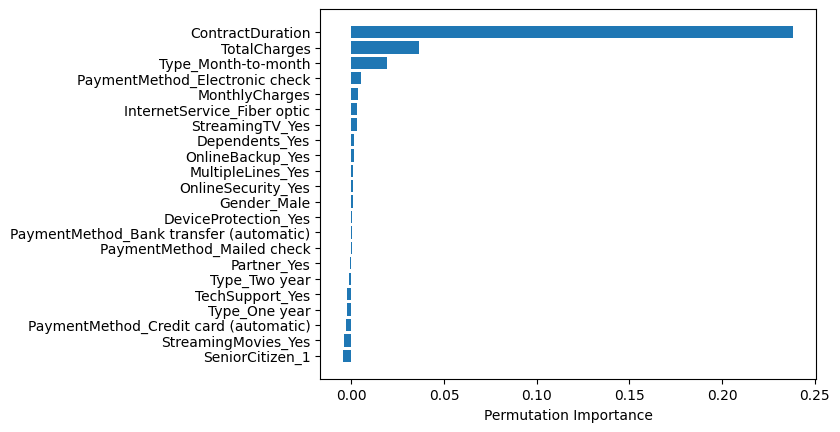

In [80]:
# Visualizar la importancia de las características
sorted_idx = result.importances_mean.argsort()
plt.barh(X_test.columns[sorted_idx], result.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")
plt.show()

<span style=color:green> **Comentario:** </span>

- En este modelo, las cinco características con mayor importancia para la cancelación de los clientes son:
    1. Duración del contrato
    2. Pagos totales realizados
    2. Contrato de pagos mensuales
    4. Pagos con cheque electrónico
    5. Pagos mensuales realizados

- Las cinco características con menos importancia para la cancelación de los clientes son:

    1. Edad avanzada
    2. Servicio de streaming de películas 
    3. Pagos con tarjeta de crédito
    4. Contratos anuales
    5. Servicio de soporte


## Conclusión

- Se probaron cuatro modelos de clasficiación: regresión logística, bosque aleatorio optimizado, Light GBM y XGBoost (optimizados)
- El **modelo de descenso de gradiente LGBM** obtuvo las mejores métricas de los modelos probados:
    - **ROC-AUC de 0.89**
    - Accuracy de 0.84
- De los datos originales, se creó una característica adicional (duración de contrato) que mostró ser la característica más relevante para la cancelación de los clientes, en todos los modelos. 
- Cada modelo otorgó importancia a distintas características, pero en el modelo con mejor performance los más relevantes fueron:
    1. Duración de contrato
    2. Pagos totales realizados
    3. Contrato de pagos mensuales
    4. Pagos con cheque electrónico
    5. Internet de fibra óptica
- De la misma manera, las características menos relevantes fueron:
    1. Contratos anuales
    2. Servicio de streaming de películas 
    3. Pagos con tarjeta de crédito
    4. Servicio de protección de dispositivos
    5. Pagos por transferencia bancaria
- La transformación y codificación de todas las variables se realizó de forma exitosa y contribuyó al buen desempeño de los modelos creados. 
- No fue necesario redimensionar los conjuntos con PCA. Hacerlo no mejoraba las métricas en los modelos.
- Con las características más relevantes, se podría crear una estrategia para enfocar los mensajes publicitarios a los clientes con predicciones positivas, y que estén por cumplir los primeros 60, 300 y 900 días de servicio y cuyos pagos totales estén por arriba del promedio obtenido para estos periodos:
    - 60 días: $76 usd
    - 300 días: $220 usd
    - 900 días: $628 usd